<a href="https://colab.research.google.com/github/Gordy-Li/Gordy-Li/blob/main/Final_Oral_Presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Oral Prsentation**

>In recent years, autonomous driving technology has gradually popular. For this technology, the most important thing is how to avoid pedestrians and vehicles. In order to detect road conditions and respond to emergencies, a car needs an "eye" and a "brain" capable of processing visual information. Obviously, it is a problem in the field of artificial intelligence. Our group will train a road condition detection model and deploy it on a mobile phone to simulate the process of self-driving cars detecting road conditions.Besides, we will use OpenVino to run a pre-trained model(pedestrian and vehicle detection) from Intel.




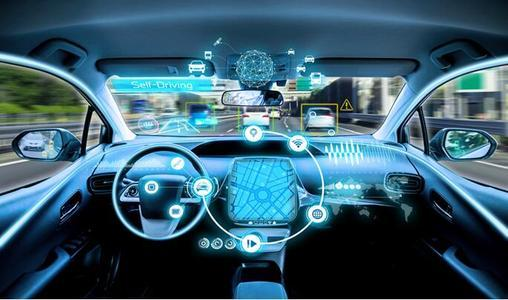









## ***Part A***

### 1.Model Training


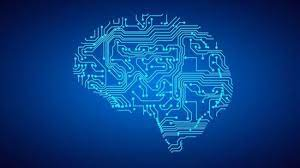

[Train the model by AutoML](https://youtu.be/7J4ilTsgUeQ)📺(Video)

### 2.Model Deployment

In [ ]:
#Code

import UIKit
import AVFoundation
import Vision

class VisionObjectRecognitionViewController: ViewController {
    
    private var detectionOverlay: CALayer! = nil
    
    // Vision parts
    private var requests = [VNRequest]()
    
    @discardableResult
    func setupVision() -> NSError? {
        // Setup Vision parts
        let error: NSError! = nil
        
        guard let modelURL = Bundle.main.url(forResource: "MyObjectDetector 1", withExtension: "mlmodelc") else {
            return NSError(domain: "VisionObjectRecognitionViewController", code: -1, userInfo: [NSLocalizedDescriptionKey: "Model file is missing"])
        }
        do {
            let visionModel = try VNCoreMLModel(for: MLModel(contentsOf: modelURL))
            let objectRecognition = VNCoreMLRequest(model: visionModel, completionHandler: { (request, error) in
                DispatchQueue.main.async(execute: {
                    // perform all the UI updates on the main queue
                    if let results = request.results {
                        self.drawVisionRequestResults(results)
                    }
                })
            })
            self.requests = [objectRecognition]
        } catch let error as NSError {
            print("Model loading went wrong: \(error)")
        }
        
        return error
    }
    
    func drawVisionRequestResults(_ results: [Any]) {
        CATransaction.begin()
        CATransaction.setValue(kCFBooleanTrue, forKey: kCATransactionDisableActions)
        detectionOverlay.sublayers = nil // remove all the old recognized objects
        for observation in results where observation is VNRecognizedObjectObservation {
            guard let objectObservation = observation as? VNRecognizedObjectObservation else {
                continue
            }
            // Select only the label with the highest confidence.
            let topLabelObservation = objectObservation.labels[0]
            let objectBounds = VNImageRectForNormalizedRect(objectObservation.boundingBox, Int(bufferSize.width), Int(bufferSize.height))
            
            let shapeLayer = self.createRoundedRectLayerWithBounds(objectBounds)
            
            let textLayer = self.createTextSubLayerInBounds(objectBounds,identifier: topLabelObservation.identifier,confidence: topLabelObservation.confidence)
            shapeLayer.addSublayer(textLayer)
            detectionOverlay.addSublayer(shapeLayer)
        }
        self.updateLayerGeometry()
        CATransaction.commit()
    }
    
    override func captureOutput(_ output: AVCaptureOutput, didOutput sampleBuffer: CMSampleBuffer, from connection: AVCaptureConnection) {
        guard let pixelBuffer = CMSampleBufferGetImageBuffer(sampleBuffer) else {
            return
        }
        
        let exifOrientation = exifOrientationFromDeviceOrientation()
        
        let imageRequestHandler = VNImageRequestHandler(cvPixelBuffer: pixelBuffer, orientation: exifOrientation, options: [:])
        do {
            try imageRequestHandler.perform(self.requests)
        } catch {
            print(error)
        }
    }
    
    override func setupAVCapture() {
        super.setupAVCapture()
        
        // setup Vision parts
        setupLayers()
        updateLayerGeometry()
        setupVision()
        
        // start the capture
        startCaptureSession()
    }
    
    func setupLayers() {
        detectionOverlay = CALayer() // container layer that has all the renderings of the observations
        detectionOverlay.name = "DetectionOverlay"
        detectionOverlay.bounds = CGRect(x: 0.0,
                                         y: 0.0,
                                         width: bufferSize.width,
                                         height: bufferSize.height)
        detectionOverlay.position = CGPoint(x: rootLayer.bounds.midX, y: rootLayer.bounds.midY)
        rootLayer.addSublayer(detectionOverlay)
    }
    
    func updateLayerGeometry() {
        let bounds = rootLayer.bounds
        var scale: CGFloat
        
        let xScale: CGFloat = bounds.size.width / bufferSize.height
        let yScale: CGFloat = bounds.size.height / bufferSize.width
        
        scale = fmax(xScale, yScale)
        if scale.isInfinite {
            scale = 1.0
        }
        CATransaction.begin()
        CATransaction.setValue(kCFBooleanTrue, forKey: kCATransactionDisableActions)
        
        // rotate the layer into screen orientation and scale and mirror
        detectionOverlay.setAffineTransform(CGAffineTransform(rotationAngle: CGFloat(.pi / 2.0)).scaledBy(x: scale, y: -scale))
        // center the layer
        detectionOverlay.position = CGPoint(x: bounds.midX, y: bounds.midY)
        
        CATransaction.commit()
        
    }
    
    func createTextSubLayerInBounds(_ bounds: CGRect, identifier: String, confidence: VNConfidence) -> CATextLayer {
        let textLayer = CATextLayer()
        textLayer.name = "Object Label"
        let formattedString = NSMutableAttributedString(string: String(format: "\(identifier)\nConfidence:  %.2f", confidence))
        let largeFont = UIFont(name: "Helvetica", size: 24.0)!
        formattedString.addAttributes([NSAttributedString.Key.font: largeFont], range: NSRange(location: 0, length: identifier.count))
        textLayer.string = formattedString
        textLayer.bounds = CGRect(x: 0, y: 0, width: bounds.size.height - 10, height: bounds.size.width - 10)
        textLayer.position = CGPoint(x: bounds.midX, y: bounds.midY)
        textLayer.shadowOpacity = 0.7
        textLayer.shadowOffset = CGSize(width: 2, height: 2)
        textLayer.foregroundColor = CGColor(colorSpace: CGColorSpaceCreateDeviceRGB(), components: [0.0, 0.0, 0.0, 1.0])
        textLayer.contentsScale = 2.0 // retina rendering
        // rotate the layer into screen orientation and scale and mirror
        textLayer.setAffineTransform(CGAffineTransform(rotationAngle: CGFloat(.pi / 2.0)).scaledBy(x: 1.0, y: -1.0))
        return textLayer
    }
    
    func createRoundedRectLayerWithBounds(_ bounds: CGRect) -> CALayer {
        let shapeLayer = CALayer()
        shapeLayer.bounds = bounds
        shapeLayer.position = CGPoint(x: bounds.midX, y: bounds.midY)
        shapeLayer.name = "Found Object"
        shapeLayer.backgroundColor = CGColor(colorSpace: CGColorSpaceCreateDeviceRGB(), components: [1.0, 1.0, 0.2, 0.4])
        shapeLayer.cornerRadius = 7
        return shapeLayer
    }
    
}

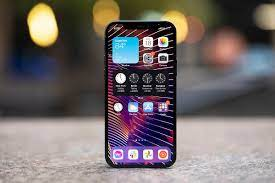

[Deploy the model on iphone](https://youtu.be/HH6qiy9-Cno)📺(Video)

## ***Part B***

In [ ]:
#Code
from openvino.inference_engine import IECore
import time
import cv2 as cv


def ssd_video_demo():
    ie = IECore()
    for device in ie.available_devices:
        print(device)

    model_xml = r"D:\PycharmProjects\OpenVINO\pedestrian-and-vehicle-detector-adas-0001.xml"
    model_bin = r"D:\PycharmProjects\OpenVINO\pedestrian-and-vehicle-detector-adas-0001.bin"

    net = ie.read_network(model=model_xml, weights=model_bin)
    input_blob = next(iter(net.input_info))
    out_blob = next(iter(net.outputs))

    n, c, h, w = net.input_info[input_blob].input_data.shape
    print(n, c, h, w)

    cap = cv.VideoCapture(r"C:\Users\allmi\Documents\Captura\2021-09-08-23-06-19.mp4")
    exec_net = ie.load_network(network=net, device_name="CPU")

    while True:
        ret, frame = cap.read()
        if ret is not True:
            break
        image = cv.resize(frame, (w, h))
        image = image.transpose(2, 0, 1)
        inf_start = time.time()
        res = exec_net.infer(inputs={input_blob:[image]})
        inf_end = time.time() - inf_start
        print("infer time(ms)：%.3f"%(inf_end*1000))
        ih, iw, ic = frame.shape
        res = res[out_blob]
        for obj in res[0][0]:
            if obj[2] > 0.5:
                xmin = int(obj[3] * iw)
                ymin = int(obj[4] * ih)
                xmax = int(obj[5] * iw)
                ymax = int(obj[6] * ih)
                cv.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 255), 2, 8)
        cv.putText(frame, "infer time(ms): %.3f, FPS: %.2f"%(inf_end*1000, 1/inf_end), (10, 50),
                   cv.FONT_HERSHEY_SIMPLEX, 1.0, (255, 0, 255), 2, 8)
        cv.namedWindow("Pedestrian Detection", cv.WINDOW_FREERATIO)
        cv.imshow("Pedestrian Detection", frame)
        c = cv.waitKey(1)
        if c == 27:
            break
    cv.waitKey(0)
    cv.destroyAllWindows()


if __name__ == "__main__":
    ssd_video_demo()


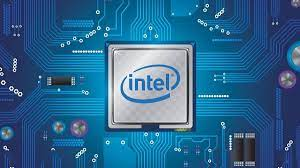

[OpenVino](https://youtu.be/kHz005CYg2c)📺(Video)